In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data/train/present/UID_35_10_3_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_6_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_7_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_2_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_4_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_8_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_11_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_2_all.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
train_path = "/content/data/data/train"
val_path = "/content/data/data/validation"
test_path = "/content/data/data/test"

In [ ]:
IMAGE_SIZE = [224,224]

In [ ]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=30,           # Rotate images by up to 30 degrees
    width_shift_range=0.05,       # Translate horizontally by 20% of the width
    height_shift_range=0.05,      # Translate vertically by 20% of the height
    shear_range=0.1,             # Apply shear transformation
    zoom_range=0.1,              # Random zoom by up to 20%
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2],)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=16,
                                              class_mode = 'categorical')

val_set = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='categorical')

Found 9616 images belonging to 2 classes.
Found 2062 images belonging to 2 classes.
Found 2060 images belonging to 2 classes.


In [ ]:

from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# EfficientNetB3

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

In [ ]:
base = EfficientNetB3(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(2, activation='softmax')(x)
# Combining base and head
model7 = Model(inputs=base.input, outputs=head)

In [ ]:
model7.summary()
model7.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,786,609 (41.15 MB)

 Trainable params: 10,699,306 (40.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [ ]:
hist7 = model7.fit(train_set, validation_data=val_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(val_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 310s 336ms/step - accuracy: 0.8183 - f1_m: 0.8183 - loss: 0.4252 - precision_m: 0.8183 - recall_m: 0.8183 - val_accuracy: 0.5000 - val_f1_m: 0.4999 - val_loss: 0.7117 - val_precision_m: 0.4999 - val_recall_m: 0.4999 - learning_rate: 0.0010
Epoch 2/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 199s 313ms/step - accuracy: 0.8830 - f1_m: 0.8830 - loss: 0.2933 - precision_m: 0.8830 - recall_m: 0.8830 - val_accuracy: 0.5000 - val_f1_m: 0.4999 - val_loss: 144.3449 - val_precision_m: 0.4999 - val_recall_m: 0.4999 - learning_rate: 0.0010
Epoch 3/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 200s 310ms/step - accuracy: 0.8971 - f1_m: 0.8971 - loss: 0.2605 - precision_m: 0.8971 - recall_m: 0.8971 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_loss: 0.9598 - val_precision_m: 0.5000 - val_recall_m: 0.5000 - learning_rate: 0.0010
Epoch 4/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9010 - f1_m: 0.9010 - loss: 0.2444 - precision_m: 0.9010 - recall_m: 0.9010
Epoch 4: Reduc

In [ ]:
from google.colab import files
model7.save(f"/content/drive/MyDrive/{'Efficientnetb3'}.h5")
#files.download(f"/content/drive/MyDrive/Efficientnetb3.h5")  # For .h5 file


In [ ]:
scores = model7.evaluate(test_set)
storeResults("EfficientNetb3", scores[1], scores[2], scores[3], scores[4])

129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.9560 - f1_m: 0.9560 - loss: 0.1345 - precision_m: 0.9560 - recall_m: 0.9560


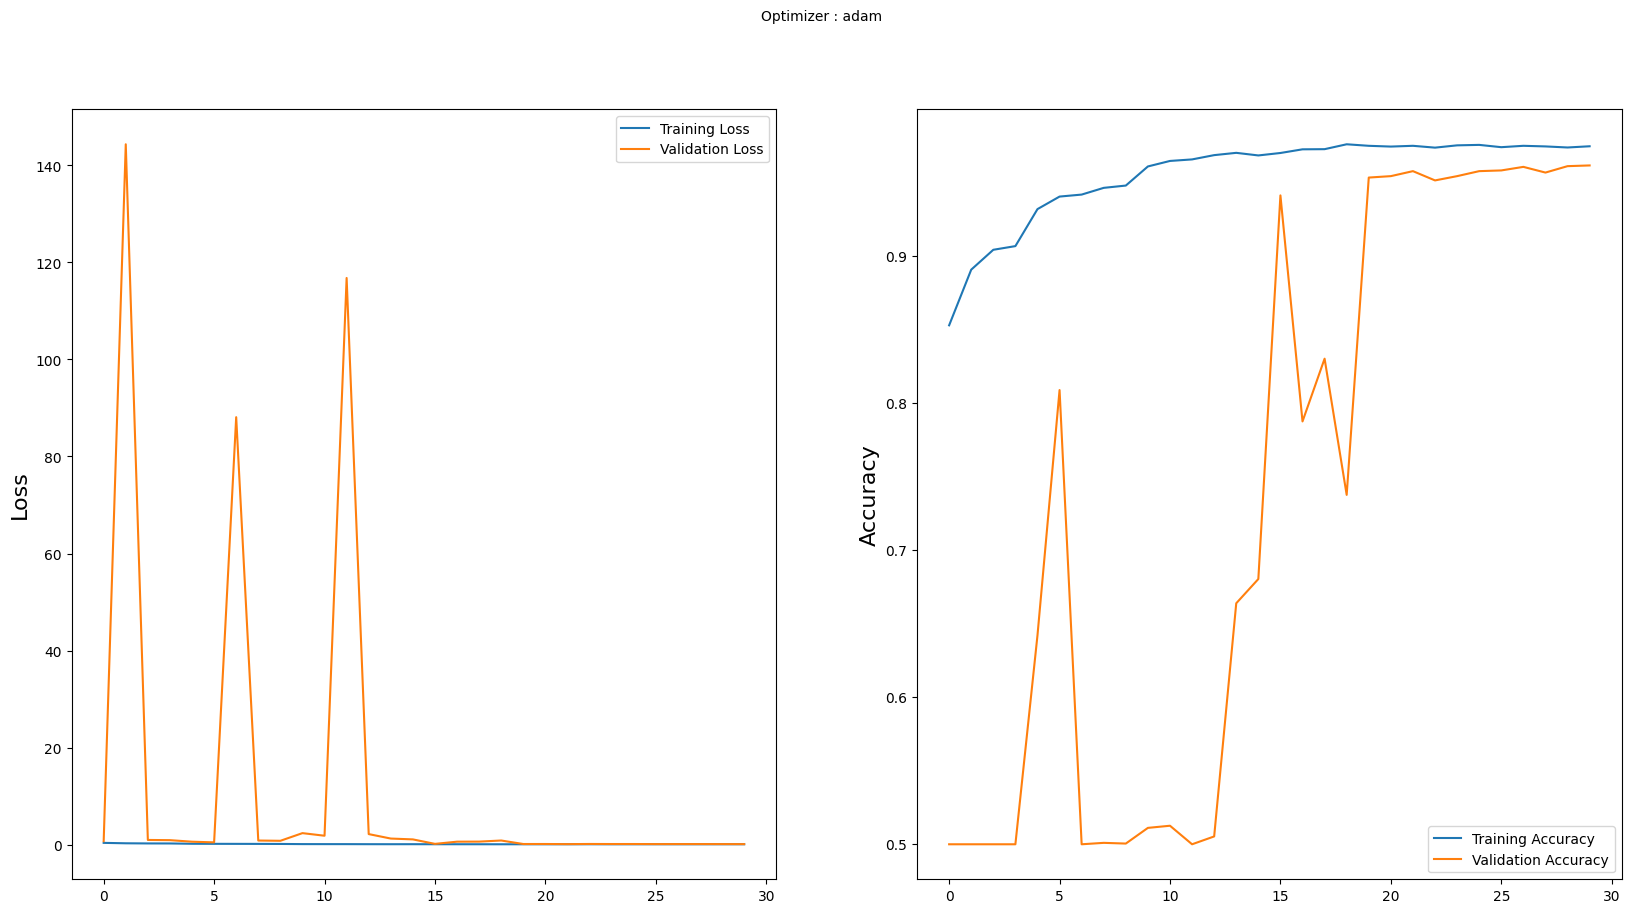

In [ ]:
import matplotlib.pyplot as plt

x=hist7
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save training history to a JSON file
import json
history_dict = hist7.history
with open(f"/content/drive/MyDrive/{'EfficientNetb3'}_history.json", "w") as f:
    json.dump(history_dict, f)



In [ ]:
print(hist7.history['accuracy'][-1])
print(hist7.history['precision_m'][-1])
print(hist7.history['recall_m'][-1])
print(hist7.history['f1_m'][-1])


0.974729597568512
0.974729597568512
0.974729597568512
0.974729597568512
